# COVID-19 Tracker
Using data on COVID-19 from the European Centre for Disease Control (via the website ourworldindata.org), and world population data from the World Bank, and the Python programming language and Jupyter (IPython) Notebook, I generated some charts to help visualize the data. You can skim the code below, and jumpt to the bottom to see the summary charts.

I have made this source code available as open source on the code sharing service GitHub (see https://github.com/bakirl/covid19-tracker) . You can also launch a Jupyter notebook live in your browser using the service called binder (see https://mybinder.org/v2/gh/bakirl/covid19-tracker/master) - this will take a few minutes to launch, after which you can click on the file (covid19.ipynb). Using this code, you can change things such as the countries and range of dates, etc.

## The Code

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from datetime import datetime

In [2]:
# filter warnings, for now!
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest Covid 19 data
world_df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
# df.date is a string, convert to a datetime object
world_df['date'] = [datetime.strptime(date, '%Y-%m-%d') for date in world_df.date]

# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop_df = pd.read_csv("population.csv", skiprows=4)
pop_df = pop_df.set_index('Country Name')
pop_df = pop_df['2018'].dropna()

In [4]:
# Default values
values_def = 'new_cases'
start_def = '2020-03-01'
end_def = '2066-05-08' # i.e. no end date (way in the future)
#countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Iran']
countries_def=[]

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [5]:
# generate a pivot of values for a specified list of countries for a specified range of dates
# @param df - data frame containing Covid 19 data by date and by country
# @param pop - data frome containing population data from 2018
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param start - show data only for dates since this date; format 'yyyy-mm-dd'
# @param locations - show data only for the specified locations
# @param by_pop - set to True to divide numbers by population per country, in 100K
def covid(df=world_df, pop=pop_df, values=values_def, start=start_def, end=end_def,
          locations=countries_def, by_pop=False, sort=True, world_strip=True):
    # filter by date
    df2 = df[df.date >= start]
    df2 = df2[df.date <= end]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    if (locations == []):
        if (world_strip):
            sub = piv.drop(columns='World')
        else:
            sub = piv
    else:
        sub = piv[locations]
    # setup title of plot
    title=values + " from " + start
    if (by_pop):
        # divide each number by the population, in 100K
        if (locations == []):
            pop2=pop
        else:
            pop2 = pop[locations]
        pop2 = pop2/1e5
        #pop2 = pop2.transpose()
        #sub = sub/pop2.values
        sub = sub/pop2
        title = title + " per 100K of population"
    if (sort):
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    return sub, title

In [6]:
# generate the sub-pivot for all countries in the covid dataframe
sub, title = covid(locations=[])

# not all countries in the covid dataframe are also in the population dataframe
# find the intersection of these two sets
countries_inter_index = pop_df.index.intersection(sub.columns)
countries_inter = countries_inter_index.values

In [7]:
# Countries with smaller populations are showing up - let's look at 40 countries with the smallest population
pop2=pop_df[countries_inter].sort_values(ascending=False)
entries=pop2.shape[0]

In [8]:
# Let's only consider countries with population greater than 1m
countries_small = pop2[pop2.values <= 1e6]
countries_large_index = countries_inter_index.difference(countries_small.index)
countries_large = countries_large_index.values

In [9]:
countries_eu27=['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 
                 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
                 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']
# removed 'Slovakia', due to lack of population data
countries_europe = countries_eu27 + ['Albania', 'Andorra', 'Armenia', 'Azerbaijan', 'Belarus',
                                     'Bosnia and Herzegovina', 'Georgia', 'Iceland', 'Kazakhstan', 'Liechtenstein', 
                                     'Moldova', 'Monaco', 'Montenegro', 'Norway', 
                                     'San Marino', 'Serbia', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom']
# 'North Macedonia', 'Russia', 'Vatican City'

In [10]:
def covid_plot1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, end=end_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values='new_cases', width=10, height=7, mult=1):
    plt.rcParams["figure.figsize"] = (width, height)
    fig, ax = plt.subplots(1, 1, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    if (mult == 1):
        suptitle += ', per day'
    else:
        suptitle += ', per ' + str(mult) + ' days'
    fig.suptitle(suptitle, size=18, weight='bold')
    
    sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                       start=start, end=end, world_strip=world_strip)
    # set rolling window
    sub = sub.rolling(window=rolling_window).mean()
    sub = sub * mult
    if (normalized):
        sub = sub/sub.max(axis=0)
    if (sort_after):
        # resort at this point as normalization etc. affects order
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    sub = sub.iloc[:, :n]
    ax1 = sub.plot(title=title, logy=False, ax=ax)
    ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
    ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=major))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%e %b'))
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    if (not normalized):
        ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [11]:
values_range_def = ['new_cases', 'total_cases', 'new_deaths', 'total_deaths']
# plot the data from the pivot in 4 charts, on for each of new cases, total cases, new deaths, total deaths
# @param n - show data from the top N countries
# @param locations - show data only for the specified locations
# @param by_pop - set to True to divide numbers by population per country, in 100K
# @param sort - if True, sort countries by highest value on last day
# @param suptitle - title to use for the set of 4 charts
# @param start_def - start date
# @param normalized - if True, normalize all values so that max value per country is 100%
#           Note, this is good for comparing the "shape"/slope of different countries with
#           very different absolute values.
# @param rolling_window - number of days over which to do a moving average
# @param major - major interval (in days) on x axis
def covid_plot4(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, end=end_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values_range=values_range_def):
    plt.rcParams["figure.figsize"] = (14, 10)
    fig, ax = plt.subplots(2, 2, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    fig.suptitle(suptitle, size=18, weight='bold')
    
    for values, axis in zip(values_range, [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
        sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                           start=start, end=end, world_strip=world_strip)
        # set rolling window
        sub = sub.rolling(window=rolling_window).mean()
        if (normalized):
            sub = sub/sub.max(axis=0)
        if (sort_after):
            # resort at this point as normalization etc. affects order
            # sort based on highest value on the most recent date (last row)
            lastrow = sub.shape[0]-1
            lastrow_name = sub.index[lastrow]
            sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
        sub = sub.iloc[:, :n]
        ax1 = sub.plot(title=title, logy=False, ax=axis)
        ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
        ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=major))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%e %b'))
        for tick in ax1.get_xticklabels():
            tick.set_rotation(45)
        if (not normalized):
            ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}')) 

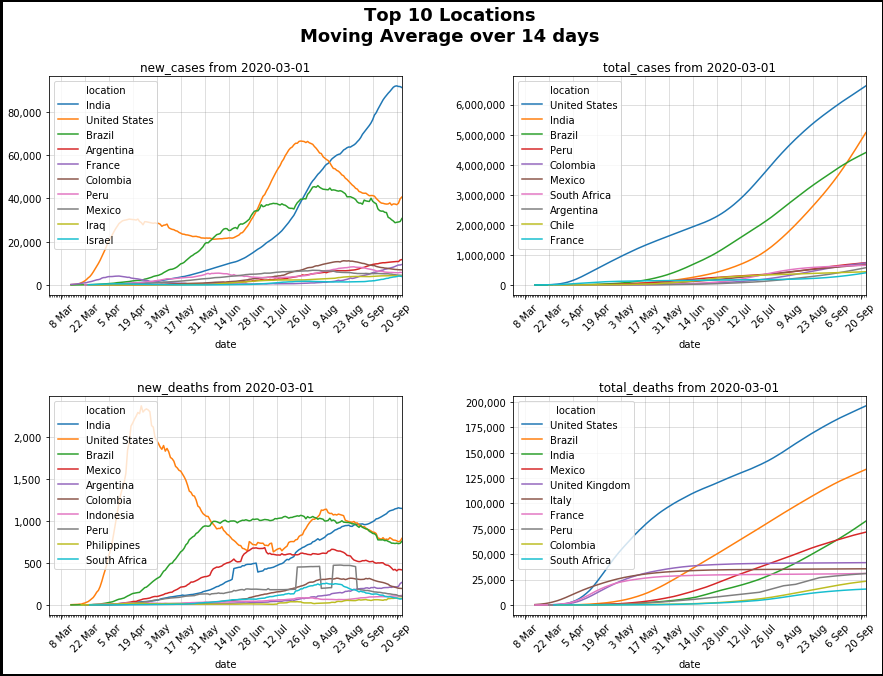

In [12]:
covid_plot4(rolling_window=14)

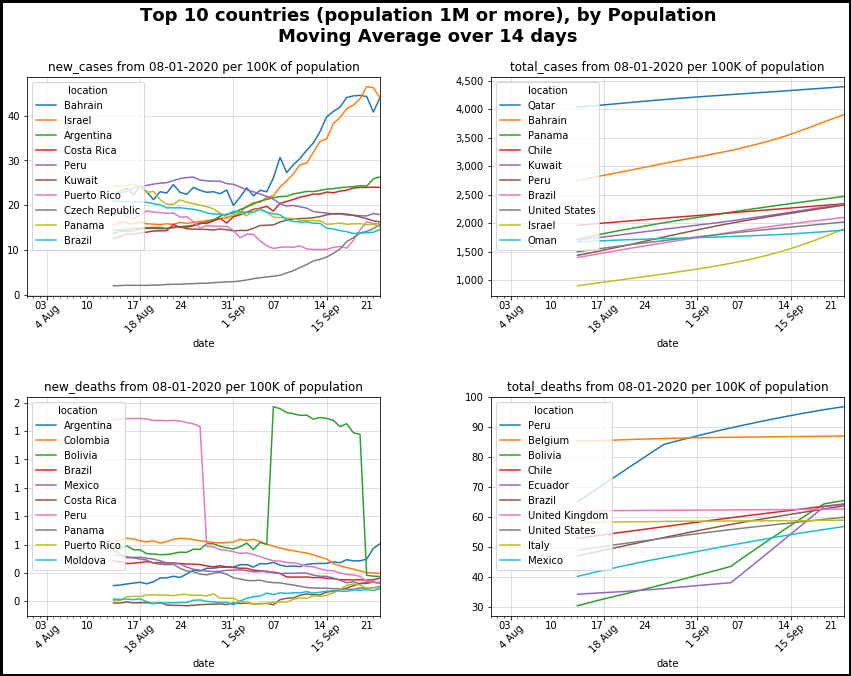

In [13]:
# when sorting by population, exclude smaller countries
covid_plot4(by_pop=True, locations=countries_large, suptitle="Top 10 countries (population 1M or more)", 
           start='08-01-2020', rolling_window=14)

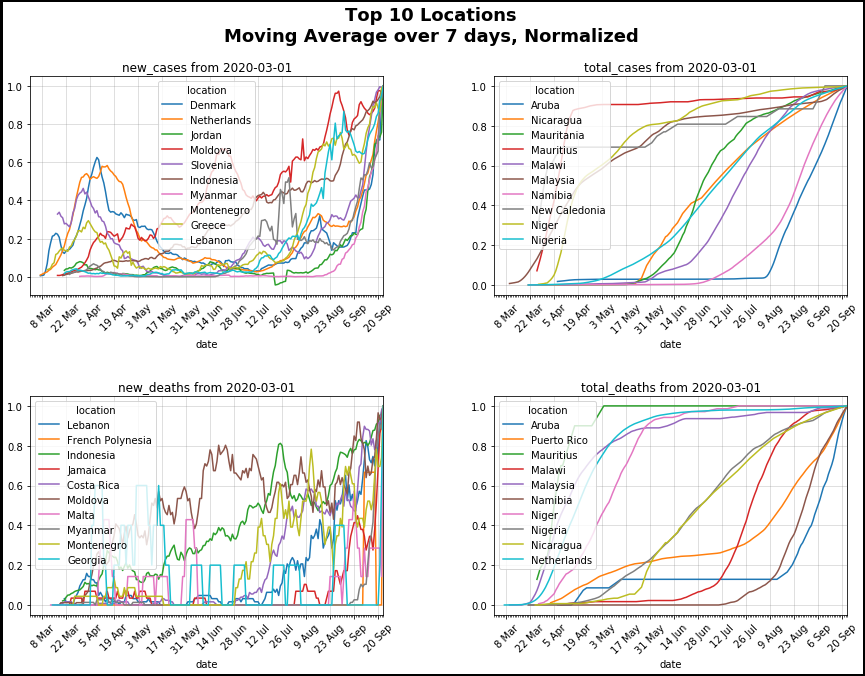

In [14]:
covid_plot4(normalized=True)

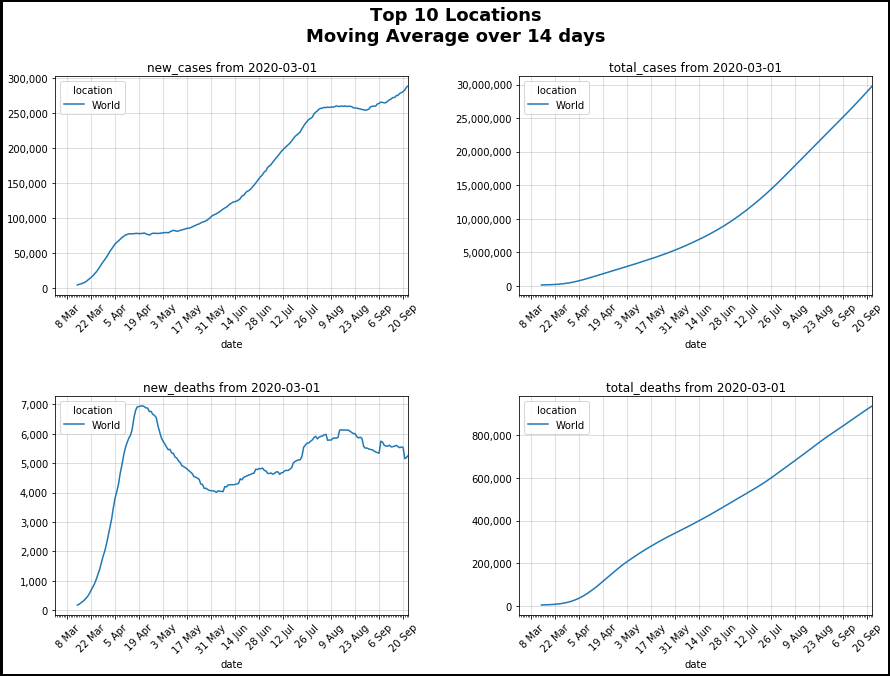

In [15]:
covid_plot4(locations=['World'], rolling_window=14)

In [16]:
# US data by state
us_df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
us_df.rename(columns={'state': 'location', 'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
us_df.drop(columns='fips', inplace=True)
# add new columns for new cases and deaths and populate by calculating diff over the corresponding totals
us_df['new_cases'] = 0
us_df['new_deaths'] = 0
for location in us_df.location.unique():
    us_df.loc[us_df.location == location, ['new_cases']] = us_df[us_df.location == location]['total_cases'].diff()
    us_df.loc[us_df.location == location, ['new_deaths']] = us_df[us_df.location == location]['total_deaths'].diff()
# df.date is a string, convert to a datetime object
us_df['date'] = [datetime.strptime(date, '%Y-%m-%d') for date in us_df.date]

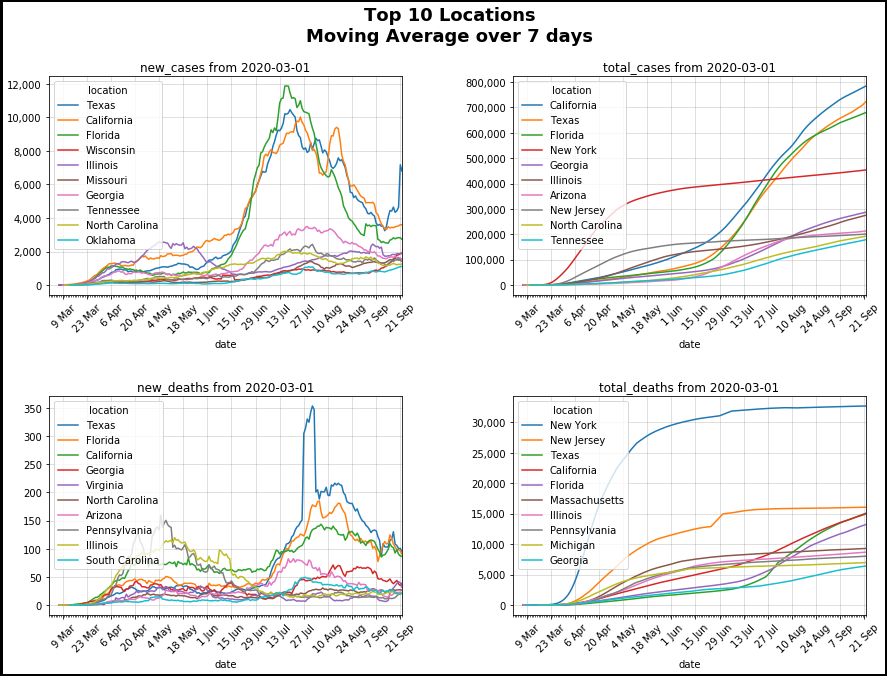

In [17]:
covid_plot4(df=us_df, locations=[], rolling_window=7, world_strip=False)

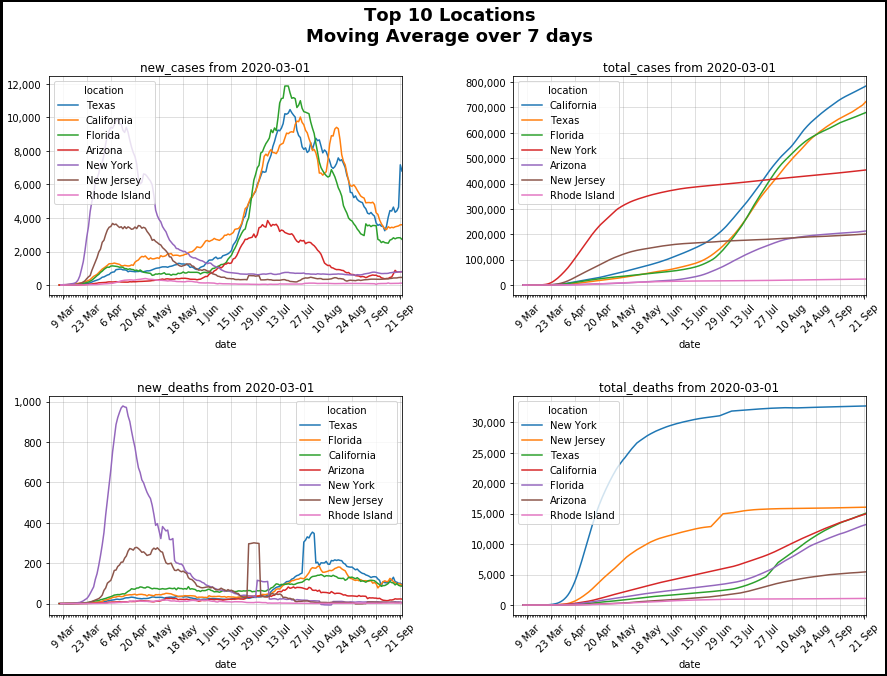

In [18]:
covid_plot4(df=us_df, locations=['Florida', 'Texas', 'California', 'New York', 'Arizona', 'New Jersey', 'Rhode Island'], 
           sort_after=True, rolling_window=7)

In [19]:
# Ireland data by county
ie_df = pd.read_csv("https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")

ie_df.rename(columns={'CountyName': 'location', 'ConfirmedCovidCases': 'total_cases', 'ConfirmedCovidDeaths': 'total_deaths'}, inplace=True)
ie_df.drop(columns=['OBJECTID', 'ORIGID', 'IGEasting', 'IGNorthing', 'Lat', 'Long'], inplace=True)
ie_df.drop(columns=['UGI', 'PopulationProportionCovidCases', 'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length'], inplace=True)
# add new columns for new cases and deaths and populate by calculating diff over the corresponding totals
ie_df['new_cases'] = 0
ie_df['new_deaths'] = 0
for location in ie_df.location.unique():
    ie_df.loc[ie_df.location == location, ['new_cases']] = ie_df[ie_df.location == location]['total_cases'].diff()
    ie_df.loc[ie_df.location == location, ['new_deaths']] = ie_df[ie_df.location == location]['total_deaths'].diff()
# df.TimeStamp is a string, convert to a datetime object
ie_df['date'] = ''
ie_df['date'] = [datetime.strptime(date[:10], '%Y/%m/%d') for date in ie_df.TimeStamp]
ie_df.drop(columns=['TimeStamp'], inplace=True)

In [20]:
ie_df

,location,PopulationCensus16,total_cases,total_deaths,new_cases,new_deaths,date
0,Carlow,56932,0,NaN,NaN,NaN,2020-02-27
1,Cavan,76176,0,NaN,NaN,NaN,2020-02-27
2,Clare,118817,0,NaN,NaN,NaN,2020-02-27
3,Cork,542868,0,NaN,NaN,NaN,2020-02-27
4,Donegal,159192,0,NaN,NaN,NaN,2020-02-27
...,...,...,...,...,...,...,...
5351,Tipperary,159553,760,NaN,1.0,NaN,2020-09-21
5352,Waterford,116176,326,NaN,5.0,NaN,2020-09-21
5353,Westmeath,88770,744,NaN,2.0,NaN,2020-09-21
5354,Wexford,149722,360,NaN,0.0,NaN,2020-09-21


In [21]:
# Looks like this error has been fixed!!!

# Turns out there's a duplicate set of rows on 29 June for some reason, 
# which prevents us from generating a pivot table.
# There's also a missing date (30 Jun); just removing the duplicate
# causes an issue with setting the "locators" on the axis.
# Instead, we change date on second 29 Jun data points to 30 Jun.
from datetime import timedelta

prev_date=datetime.today()
for location in ie_df.location.unique():
    for date in ie_df[ie_df.location==location].date:
        if (date==prev_date):
            print(f"Duplicate: location={location}, date={str(date)[:10]}")
            next_date = date+timedelta(days=1)
        prev_date = date

# next date should be 30 Jun
# next_date

# set max_rows to None (default 10) to see all rows
# pd.set_option('display.max_rows', None)
# ie_df[ie_df.date=='2020-06-30']

#ie_df = ie_df.drop_duplicates(['location','date'], keep= 'first')
# 
# replace duplicates (29 Jun) with the following date (30 Jun)
#ie_df.loc[ie_df.duplicated(['location', 'date']), ['date']] = next_date

In [22]:
# extract population of Ireland by county
ie_pop_df = ie_df[ie_df.date=='2020-06-30'].set_index('location')
ie_pop_df = ie_pop_df['PopulationCensus16']
#ie_pop_df.drop(columns=['total_cases', 'total_deaths', 'new_cases', 'new_deaths', 'date'], inplace=True)

all_counties = ie_df.location.unique()

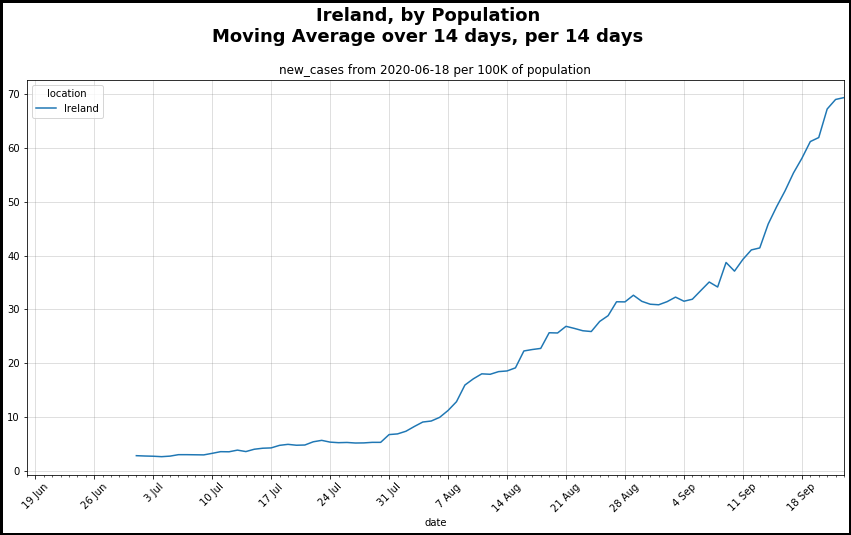

In [23]:

covid_plot1(locations=['Ireland'], by_pop=True,
            start='2020-06-18', rolling_window=14, mult=14, major=7,
            width=14, height=8, n=26, suptitle='Ireland')

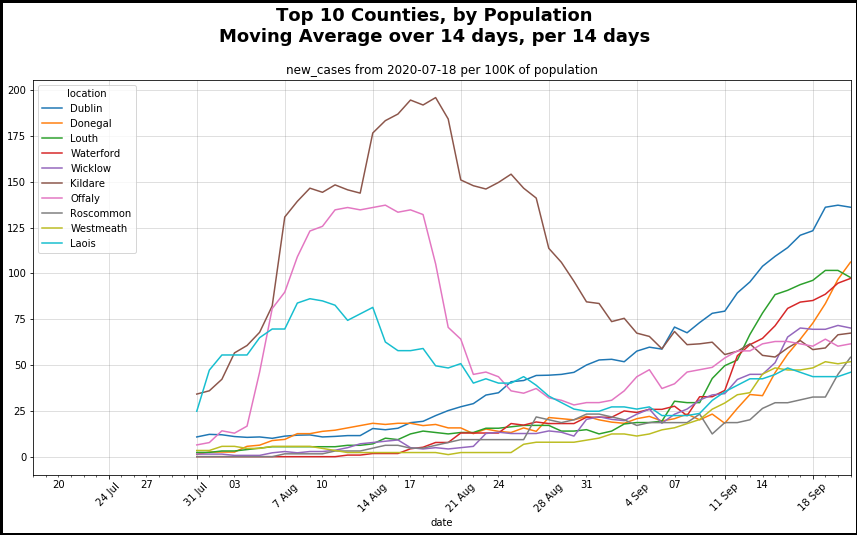

In [24]:
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, 
            start='2020-07-18', rolling_window=14, mult=14, major=7,
            width=14, height=8, n=10, suptitle='Top 10 Counties')

In [25]:
def covid_piv1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, 
               start=start_def, normalized=False, rolling_window=7, sort_after=True, world_strip=True,
              values='new_cases', mult=1):
    sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                       start=start, world_strip=world_strip)
    # set rolling window
    sub = sub.rolling(window=rolling_window).mean()
    sub = sub * mult
    if (normalized):
        sub = sub/sub.max(axis=0)
    if (sort_after):
        # resort at this point as normalization etc. affects order
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    sub = sub.iloc[:, :n]
    return sub

In [26]:
piv = covid_piv1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, start='2020-07-18', 
                 rolling_window=14, n=26, mult=14)
piv.tail(7).round(2).transpose()

date,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21
location,,,,,,,
Dublin,109.32,114.08,120.83,123.28,136.12,137.23,136.12
Donegal,45.86,55.91,64.07,72.87,83.55,96.74,106.16
Louth,88.45,90.78,93.88,96.21,101.64,101.64,97.76
Waterford,71.44,80.91,84.35,85.22,88.66,94.68,97.27
Wicklow,51.26,65.30,70.21,69.51,69.51,71.62,70.21
Kildare,54.38,59.32,63.37,58.43,59.32,66.52,67.41
Offaly,62.85,62.85,61.57,60.29,64.13,60.29,61.57
Roscommon,29.44,29.44,30.99,32.54,32.54,44.93,54.23
Westmeath,48.44,47.31,47.31,48.44,51.82,50.69,51.82


In [93]:
# Some countries don't seem to report on latest date, e.g. Spain, Sweden - see logic below
# as a result, plot based on previous date
import numpy as np

total_countries = world_df.location.unique()
total_num = total_countries.shape[0]

latest_date = world_df.loc[world_df.shape[0]-1].date
latest_countries = world_df[world_df.date == latest_date].location
latest_num = latest_countries.shape[0]
latest_miss = np.setdiff1d(total_countries, latest_countries)

prev_date = latest - timedelta(days=1)
prev_countries = world_df[world_df.date == prev_date].location
prev_num = prev_countries.shape[0]
prev_miss = np.setdiff1d(total_countries, prev_countries)

print(f'total = {total_num}, latest = {latest_num}, missing {latest_miss}, prev = {prev_num}, missing {prev_miss}')

total = 211, latest = 208, missing ['International' 'Spain' 'Sweden'], prev = 210, missing ['International']


In [27]:
#ie_df.tail(26).sort_values(by='new_cases', ascending=False)

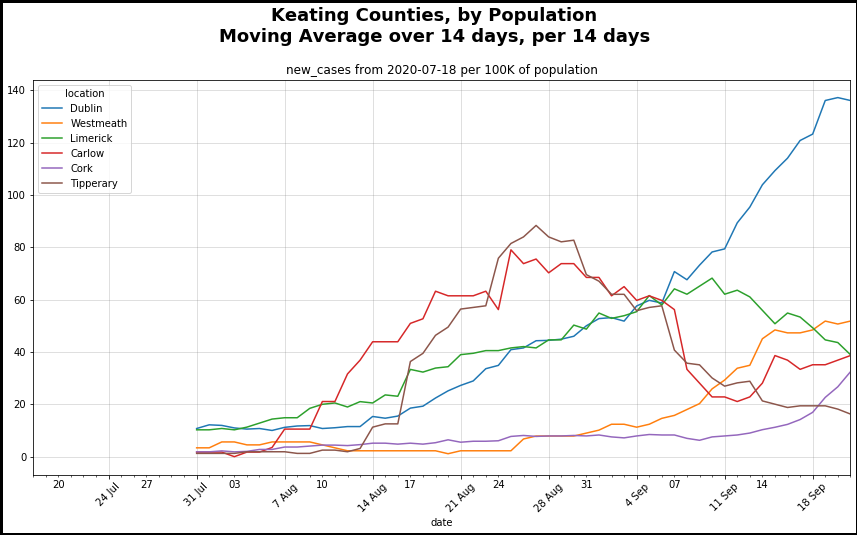

In [28]:
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=['Tipperary', 'Carlow', 'Cork', 'Dublin', 'Westmeath', 'Limerick'], world_strip=False, 
            start='2020-07-18', rolling_window=14, mult=14, major=7,
            width=14, height=8, n=10, suptitle='Keating Counties')

In [29]:
world_df[world_df.location=='Ireland']

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
20088,2019-12-31,Ireland,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
20089,2020-01-01,Ireland,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
20090,2020-01-02,Ireland,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
20091,2020-01-03,Ireland,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
20092,2020-01-04,Ireland,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20351,2020-09-19,Ireland,248.0,3.0,32271.0,1792.0,1700.0,11.0,2968.0,15.0
20352,2020-09-20,Ireland,267.0,0.0,32538.0,1792.0,1808.0,9.0,3004.0,15.0
20353,2020-09-21,Ireland,395.0,0.0,32933.0,1792.0,1948.0,8.0,3261.0,15.0
20354,2020-09-22,Ireland,188.0,0.0,33121.0,1792.0,1929.0,8.0,3347.0,15.0


In [30]:
ie_df.tail(26)

,location,PopulationCensus16,total_cases,total_deaths,new_cases,new_deaths,date
5330,Carlow,56932,277,NaN,1.0,NaN,2020-09-21
5331,Cavan,76176,919,NaN,0.0,NaN,2020-09-21
5332,Clare,118817,536,NaN,5.0,NaN,2020-09-21
5333,Cork,542868,1841,NaN,34.0,NaN,2020-09-21
5334,Donegal,159192,719,NaN,18.0,NaN,2020-09-21
5335,Dublin,1347359,15882,NaN,165.0,NaN,2020-09-21
5336,Galway,258058,628,NaN,10.0,NaN,2020-09-21
5337,Kerry,147707,371,NaN,3.0,NaN,2020-09-21
5338,Kildare,222504,2497,NaN,29.0,NaN,2020-09-21
5339,Kilkenny,99232,443,NaN,1.0,NaN,2020-09-21


# Summary

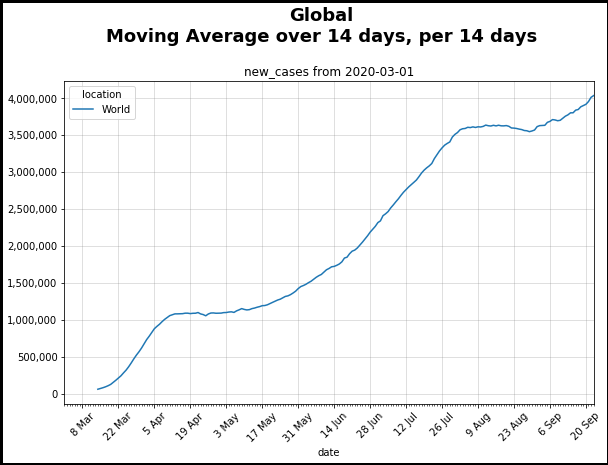

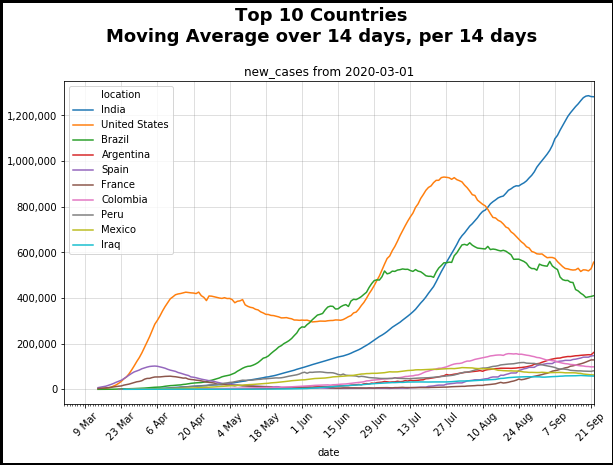

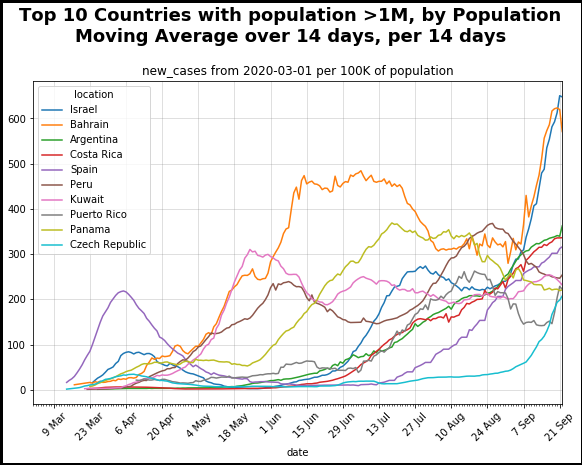

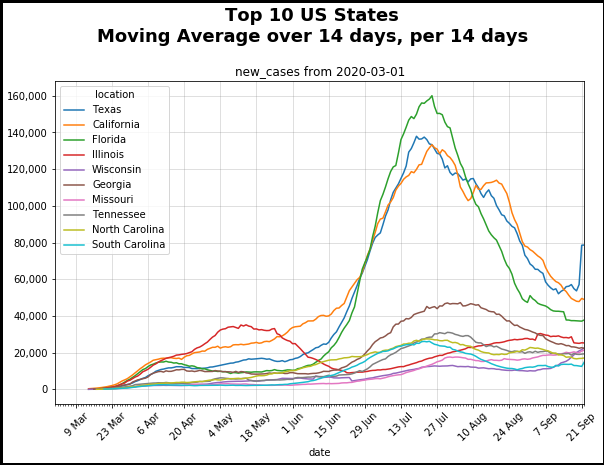

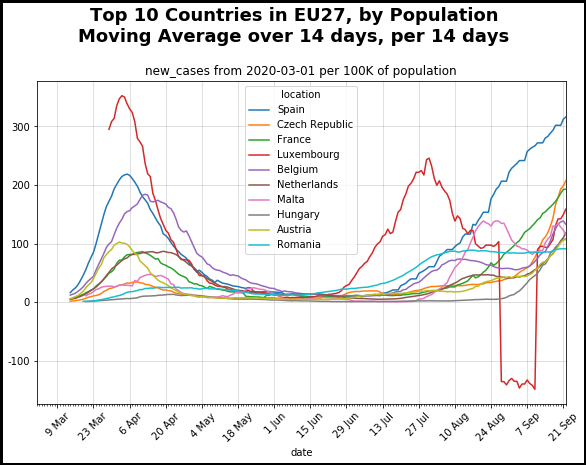

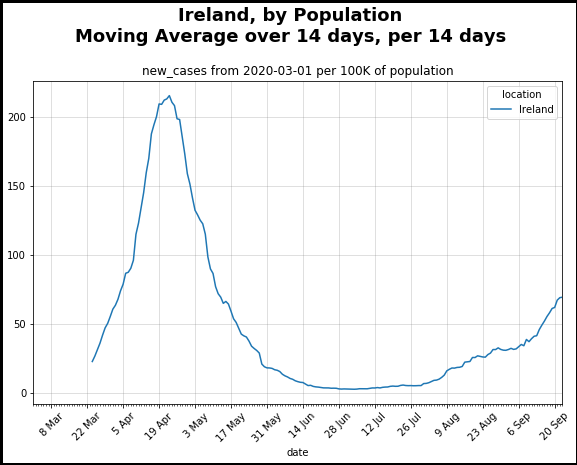

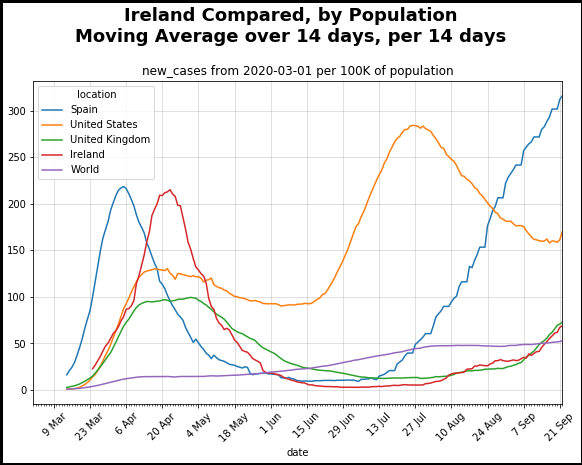

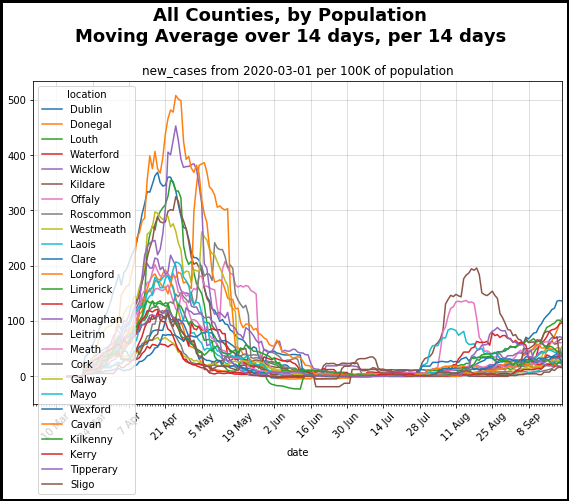

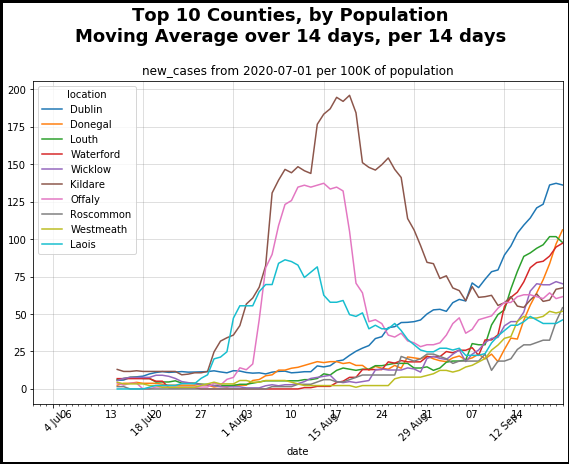

In [97]:
covid_plot1(rolling_window=14, mult=14, locations=['World'], suptitle="Global")
covid_plot1(rolling_window=14, mult=14, suptitle="Top 10 Countries", 
            end=prev_date)
covid_plot1(rolling_window=14, mult=14, by_pop=True, 
            locations=countries_large, 
            suptitle="Top 10 Countries with population >1M", 
            end=prev_date)
covid_plot1(df=us_df, locations=[], world_strip=False, rolling_window=14, mult=14, suptitle='Top 10 US States')
covid_plot1(rolling_window=14, mult=14, 
            locations=countries_eu27, suptitle="Top 10 Countries in EU27", 
            end=prev_date, by_pop=True) 
covid_plot1(rolling_window=14, mult=14, 
            locations=['Ireland'], suptitle="Ireland", 
            by_pop=True)
covid_plot1(rolling_window=14, mult=14, 
            locations=['Ireland', 'World', 'United States', 'United Kingdom', 'Spain'], suptitle="Ireland Compared", 
            end=prev_date, by_pop=True)
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, 
            rolling_window=14, mult=14, n=26, suptitle='All Counties')
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, 
            rolling_window=14, mult=14, suptitle='Top 10 Counties', start='2020-07-01')